# Lecture 01: ML Harms and Fairness Fundamentals

## Learning Objectives
By the end of this lecture, you will be able to:
- Identify different types of ML harms with real-world examples
- Understand why ML systems can perpetuate or amplify bias
- Recognize the difference between fairness in ML and general notions of fairness
- Explain why high accuracy doesn't guarantee fairness
- Discuss the tension between fairness and accuracy

**Prerequisites:** Basic ML concepts, classification metrics

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
print('✓ Ready to explore ML fairness!')

✓ Ready to explore ML fairness!


## 1. Why Fairness Matters: Real-World Harms

### The Problem

ML systems are deployed in **high-stakes decisions** affecting people's lives:
- **Criminal justice:** Bail, sentencing, parole decisions
- **Hiring:** Resume screening, interview selection
- **Lending:** Loan approval, interest rates
- **Healthcare:** Treatment recommendations, risk assessment
- **Education:** College admissions, student evaluation

**When these systems are biased, real people are harmed.**

### Case Study 1: COMPAS Recidivism Prediction

**Background (ProPublica, 2016):**
- COMPAS: Risk assessment tool used in criminal justice
- Predicts likelihood of re-offense (recidivism)
- Used for bail, sentencing, and parole decisions
- Affects thousands of defendants annually

**The Findings:**
- **Black defendants:** Wrongly labeled high-risk at **2x** the rate of white defendants
- **White defendants:** Wrongly labeled low-risk at **2x** the rate of black defendants
- High overall accuracy (67%) **masked these disparities**

**The Impact:**
- Longer sentences for black defendants
- Denied bail more often
- Real people spent more time in jail

**Key Lesson:** High accuracy doesn't mean fairness!

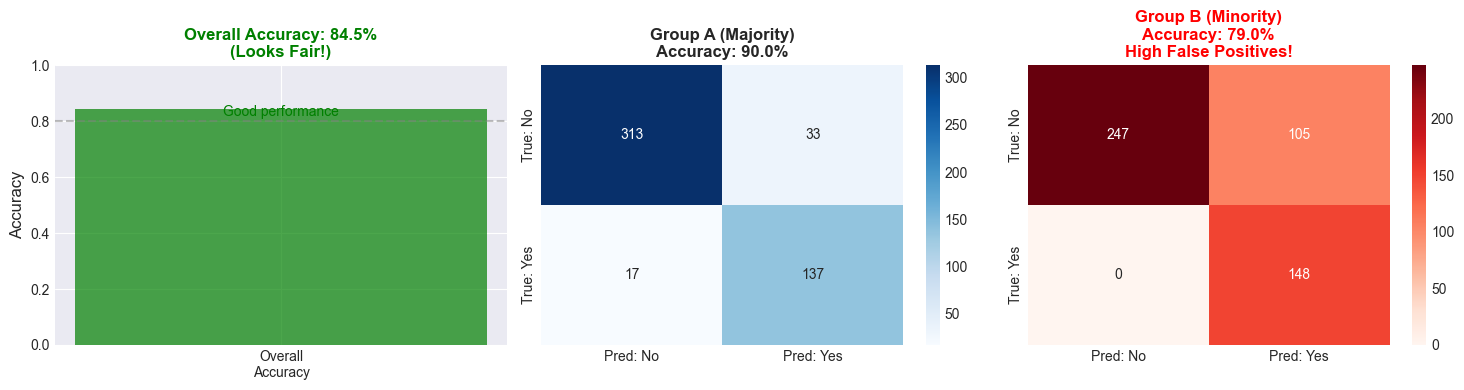


📊 The Hidden Bias:
  Overall accuracy: 84.5% (Looks great!)
  Group A accuracy: 90.0%
  Group B accuracy: 79.0%

⚠️  Group B has 105 false positives (wrongly predicted to reoffend)
     vs Group A with only 33 false positives

💡 High overall accuracy HIDES disparate impact on Group B!


In [4]:
# Simulate COMPAS-like scenario to show how bias can hide in high accuracy
np.random.seed(42)

# Simulate predictions for two groups
n_per_group = 500

# Group A (majority): High accuracy
y_true_A = np.random.binomial(1, 0.3, n_per_group)  # 30% recidivism rate
y_pred_A = y_true_A.copy()
# Add some random errors (10% error rate)
errors_A = np.random.choice(n_per_group, int(n_per_group * 0.1), replace=False)
y_pred_A[errors_A] = 1 - y_pred_A[errors_A]

# Group B (minority): Same base rate, but biased predictions
y_true_B = np.random.binomial(1, 0.3, n_per_group)  # Same 30% recidivism rate
y_pred_B = y_true_B.copy()
# Systematically over-predict recidivism (false positives)
non_recid = np.where(y_true_B == 0)[0]
fp_B = np.random.choice(non_recid, int(len(non_recid) * 0.3), replace=False)  # 30% false positive rate
y_pred_B[fp_B] = 1

# Calculate accuracies
acc_A = accuracy_score(y_true_A, y_pred_A)
acc_B = accuracy_score(y_true_B, y_pred_B)
acc_overall = accuracy_score(np.concatenate([y_true_A, y_true_B]), 
                             np.concatenate([y_pred_A, y_pred_B]))

# Confusion matrices
cm_A = confusion_matrix(y_true_A, y_pred_A)
cm_B = confusion_matrix(y_true_B, y_pred_B)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall accuracy (looks good!)
axes[0].bar(['Overall\nAccuracy'], [acc_overall], color='green', alpha=0.7)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title(f'Overall Accuracy: {acc_overall:.1%}\n(Looks Fair!)', 
                 fontsize=12, fontweight='bold', color='green')
axes[0].axhline(0.8, color='gray', linestyle='--', alpha=0.5)
axes[0].text(0, 0.82, 'Good performance', ha='center', fontsize=10, color='green')

# Group A confusion matrix
sns.heatmap(cm_A, annot=True, fmt='d', cmap='Blues', ax=axes[1],
           xticklabels=['Pred: No', 'Pred: Yes'],
           yticklabels=['True: No', 'True: Yes'])
axes[1].set_title(f'Group A (Majority)\nAccuracy: {acc_A:.1%}', 
                 fontsize=12, fontweight='bold')

# Group B confusion matrix (shows bias!)
sns.heatmap(cm_B, annot=True, fmt='d', cmap='Reds', ax=axes[2],
           xticklabels=['Pred: No', 'Pred: Yes'],
           yticklabels=['True: No', 'True: Yes'])
axes[2].set_title(f'Group B (Minority)\nAccuracy: {acc_B:.1%}\nHigh False Positives!', 
                 fontsize=12, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print(f"\n📊 The Hidden Bias:")
print(f"  Overall accuracy: {acc_overall:.1%} (Looks great!)")
print(f"  Group A accuracy: {acc_A:.1%}")
print(f"  Group B accuracy: {acc_B:.1%}")
print(f"\n⚠️  Group B has {cm_B[0,1]} false positives (wrongly predicted to reoffend)")
print(f"     vs Group A with only {cm_A[0,1]} false positives")
print(f"\n💡 High overall accuracy HIDES disparate impact on Group B!")

## 2. Types of ML Harms

### Framework: Three Main Types

#### 1. Allocation Harms
**Definition:** Withholding opportunities, resources, or information

**Examples:**
- Denying loans to qualified applicants
- Not showing job ads to certain demographics
- Rejecting college applications unfairly

**Impact:** Tangible, immediate, measurable

#### 2. Representational Harms
**Definition:** Reinforcing stereotypes or demeaning certain groups

**Examples:**
- Image search showing mostly men for "CEO"
- Translation systems defaulting to male pronouns for doctors
- AI assistants with submissive female voices

**Impact:** Subtle, cumulative, shapes perceptions

#### 3. Quality of Service Harms
**Definition:** System works poorly for certain groups

**Examples:**
- Speech recognition worse for accented speakers
- Facial recognition failing on darker skin tones
- Medical AI underperforming on women

**Impact:** Differential access to technology benefits

### Case Study 2: Gender Shades (Buolamwini & Gebru, 2018)

**Study:** Tested commercial facial recognition on faces varying by:
- Gender (Male/Female)
- Skin tone (Lighter/Darker)

**Results:**

| Group | Error Rate |
|-------|------------|
| Lighter-skinned males | 0.8% |
| Lighter-skinned females | 7.1% |
| Darker-skinned males | 12.0% |
| **Darker-skinned females** | **34.7%** |

**Type of Harm:** Quality of Service

**Root Cause:**
- Training data over-represented lighter-skinned males
- Intersectional bias (gender + race)
- Testing only on average accuracy

**Impact:**
- Led to moratoria on police use of facial recognition
- Companies withdrew products
- Changed industry practices

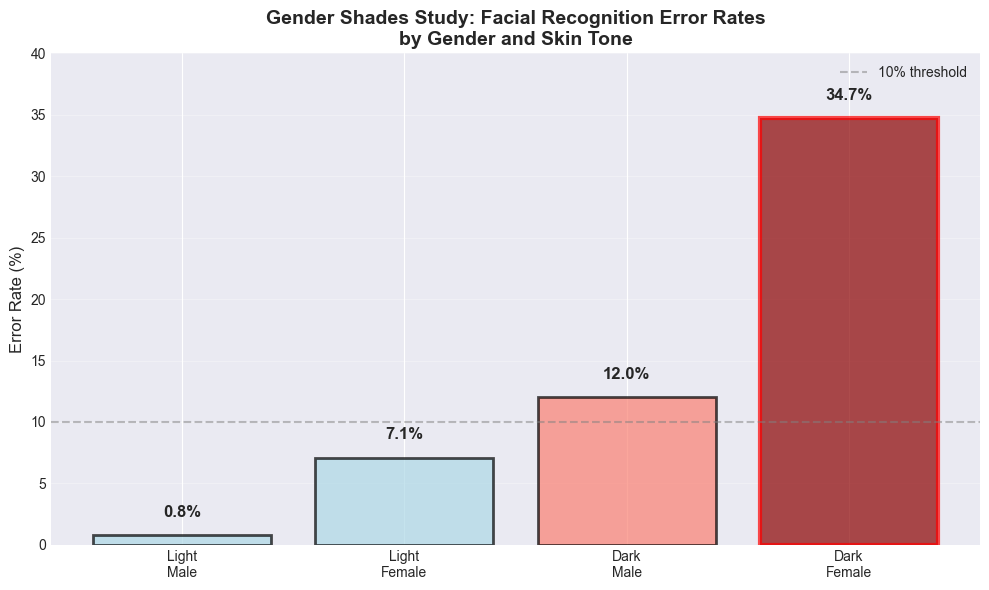


⚠️  Intersectional Bias:
  Darker-skinned females had error rate 43x higher
  than lighter-skinned males!

💡 This is Quality of Service harm - system works poorly for some groups


In [10]:
# Visualize the Gender Shades findings
groups = ['Light\nMale', 'Light\nFemale', 'Dark\nMale', 'Dark\nFemale']
error_rates = [0.8, 7.1, 12.0, 34.7]
colors = ['lightblue', 'lightblue', 'salmon', 'darkred']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(groups, error_rates, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Highlight the worst group
bars[3].set_edgecolor('red')
bars[3].set_linewidth(3)

ax.set_ylabel('Error Rate (%)', fontsize=12)
ax.set_title('Gender Shades Study: Facial Recognition Error Rates\nby Gender and Skin Tone', 
            fontsize=14, fontweight='bold')
ax.axhline(10, color='gray', linestyle='--', alpha=0.5, label='10% threshold')

# Add value labels on bars
for i, (group, rate) in enumerate(zip(groups, error_rates)):
    ax.text(i, rate + 1.5, f'{rate}%', ha='center', fontsize=12, fontweight='bold')

ax.set_ylim(0, 40)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n⚠️  Intersectional Bias:")
print(f"  Darker-skinned females had error rate {error_rates[3] / error_rates[0]:.0f}x higher")
print(f"  than lighter-skinned males!")
print(f"\n💡 This is Quality of Service harm - system works poorly for some groups")

## 3. Why ML Systems Can Be Biased

### Source 1: Historical Bias in Training Data

**Problem:** Training data reflects historical inequalities

**Example:** Hiring AI trained on resumes
- Past 10 years: Tech industry male-dominated
- Training data: 90% male hires for engineering
- Model learns: Engineering = Male
- Result: Penalizes female candidates

**Key Point:** "Garbage in, garbage out" - biased data → biased model

### Source 2: Representation Bias

**Problem:** Training data doesn't represent all groups

**Example:** Facial recognition
- Most public face datasets: Predominantly lighter skin
- Model optimized for majority group
- Poor performance on underrepresented groups

**Key Point:** Model quality correlates with data quantity

### Source 3: Measurement Bias

**Problem:** Labels or features are biased proxies

**Example:** Healthcare risk scores
- Using "past healthcare costs" as proxy for "health needs"
- Black patients have lower historical costs (less access)
- Model underestimates their health needs

**Key Point:** Proxies can encode discrimination

### Source 4: Aggregation Bias

**Problem:** One-size-fits-all models ignore group differences

**Example:** Medical AI
- Model trained mostly on men
- Heart attack symptoms different in women
- Model fails to detect women's heart attacks

**Key Point:** Average performance hides subgroup failures

## 4. Why "Just Remove Protected Attributes" Doesn't Work

### Common Misconception

**Naive approach:** Remove race, gender, age from features

**Why this fails:**
1. **Proxy variables** still contain information
2. **Correlations** exist in real data
3. **Historical bias** remains in patterns

### Demonstration: Proxies Everywhere

🔍 Correlation Analysis:

             race   zipcode    income
race     1.000000  0.999983  0.675252
zipcode  0.999983  1.000000  0.675172
income   0.675252  0.675172  1.000000


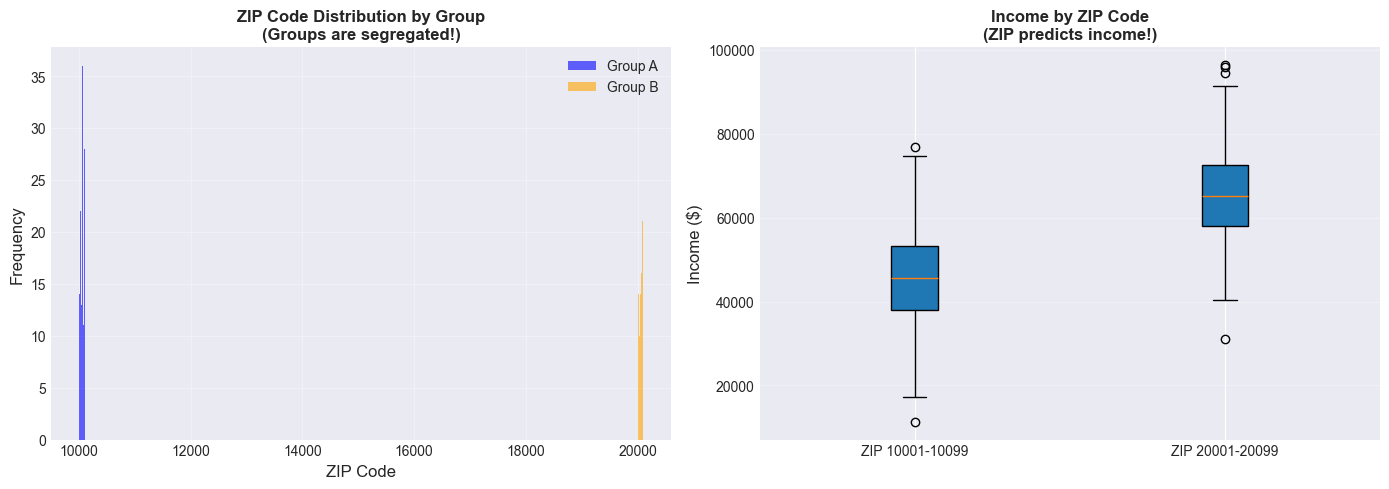


⚠️  Key Finding:
  Correlation between ZIP and race: 1.00
  Correlation between ZIP and income: 0.68

💡 Even if we remove 'race', ZIP code is a PROXY!
   Model can still discriminate through ZIP code.


In [11]:
# Demonstrate how proxy variables leak protected information
np.random.seed(42)

# Simulate data where ZIP code is proxy for race
n_samples = 1000

# Group A (coded as 0): Predominantly in ZIP 10001-10099
race_A = np.zeros(500)
zip_A = np.random.randint(10001, 10100, 500)
income_A = np.random.normal(45000, 10000, 500)  # Lower average income

# Group B (coded as 1): Predominantly in ZIP 20001-20099
race_B = np.ones(500)
zip_B = np.random.randint(20001, 20100, 500)
income_B = np.random.normal(65000, 10000, 500)  # Higher average income

# Combine
race = np.concatenate([race_A, race_B])
zipcode = np.concatenate([zip_A, zip_B])
income = np.concatenate([income_A, income_B])

# Create DataFrame
df = pd.DataFrame({
    'race': race,
    'zipcode': zipcode,
    'income': income
})

# Show correlation
print("🔍 Correlation Analysis:\n")
print(df.corr())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ZIP code distribution by race
axes[0].hist(zip_A, bins=30, alpha=0.6, label='Group A', color='blue')
axes[0].hist(zip_B, bins=30, alpha=0.6, label='Group B', color='orange')
axes[0].set_xlabel('ZIP Code', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('ZIP Code Distribution by Group\n(Groups are segregated!)', 
                 fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Income by ZIP ranges
zip_range_A = (zipcode >= 10001) & (zipcode < 10100)
zip_range_B = (zipcode >= 20001) & (zipcode < 20100)
axes[1].boxplot([income[zip_range_A], income[zip_range_B]], 
               labels=['ZIP 10001-10099', 'ZIP 20001-20099'],
               patch_artist=True)
axes[1].set_ylabel('Income ($)', fontsize=12)
axes[1].set_title('Income by ZIP Code\n(ZIP predicts income!)', 
                 fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n⚠️  Key Finding:")
print(f"  Correlation between ZIP and race: {df['zipcode'].corr(df['race']):.2f}")
print(f"  Correlation between ZIP and income: {df['zipcode'].corr(df['income']):.2f}")
print(f"\n💡 Even if we remove 'race', ZIP code is a PROXY!")
print(f"   Model can still discriminate through ZIP code.")

### Other Common Proxies

**Protected Attribute → Proxies:**

- **Race:**
  - ZIP code
  - School attended
  - First name
  - Shopping patterns
  
- **Gender:**
  - First name
  - Height/weight
  - Shopping patterns
  - Occupation
  
- **Age:**
  - Job title
  - Technology use patterns
  - Education year

**Solution:** Need fairness-aware methods, not just feature removal!

## 5. The Fairness-Accuracy Trade-off

### The Tension

**Often:**
- Maximizing accuracy → unfair outcomes
- Enforcing fairness → reduced accuracy

**Why?**
- Historical patterns in data are discriminatory
- Optimal prediction uses all patterns (including discriminatory ones)
- Fairness constraints limit which patterns can be used

### Important Nuances

**1. Whose accuracy?**
- "High average accuracy" can mask low accuracy for minorities
- Fairness constraints can improve worst-group accuracy

**2. What's the cost?**
- In some applications, small accuracy drop is acceptable
- In others, both fairness AND accuracy are critical

**3. Better data helps**
- More diverse, representative data reduces trade-off
- Fairness constraints often reveal data quality issues

## 6. What IS Fairness in ML?

### Key Insight: No Single Definition!

**Different stakeholders want different things:**

**Employers:** Hire the most qualified (individual fairness)

**Society:** Ensure equal opportunity across groups (group fairness)

**Individuals:** Treat me based on my characteristics (no stereotyping)

### Main Approaches

#### 1. Individual Fairness
**Principle:** "Similar people should be treated similarly"

**Challenge:** Defining "similar" without encoding bias

#### 2. Group Fairness
**Principle:** "Groups should be treated equally" (by some metric)

**Challenge:** Which metric? Multiple incompatible options!

#### 3. Causal Fairness
**Principle:** "Decisions shouldn't depend on protected attributes (even indirectly)"

**Challenge:** Requires causal models, hard to implement

### Next Lecture Preview

Next, we'll learn specific **fairness metrics** to measure group fairness:
- Demographic Parity
- Equalized Odds
- Predictive Parity
- And why we can't satisfy all of them simultaneously!

## Summary

### Key Takeaways

1. **ML systems can cause real harm** through allocation, representation, or quality of service

2. **High accuracy ≠ fairness** - can have high overall accuracy with severe bias

3. **Bias sources:**
   - Historical bias in training data
   - Representation bias (missing groups)
   - Measurement bias (flawed proxies)
   - Aggregation bias (one-size-fits-all)

4. **Removing protected attributes doesn't work** - proxy variables exist

5. **Fairness is complex:**
   - No single "fair" definition
   - Often trade-offs with accuracy
   - Context and values matter

6. **Real-world cases:** COMPAS, Gender Shades, Amazon hiring, healthcare algorithms

### Practical Implications

**DO:**
- Measure fairness explicitly (not just accuracy)
- Disaggregate metrics by protected groups
- Consider multiple fairness definitions
- Document known biases
- Involve affected stakeholders

**DON'T:**
- Assume accuracy implies fairness
- Just remove protected attributes
- Ignore historical context
- Deploy without fairness assessment
- Claim your model is "unbiased"

### Looking Ahead

**Next lectures:**
- Lecture 02: Specific fairness metrics and how to measure them
- Lecture 03: Explaining model decisions (LIME, SHAP)
- Lecture 04: Responsible AI practices (privacy, documentation)

**Remember:** Fairness in ML is an ongoing process, not a one-time fix!

## Reflection Questions

1. Can you think of an ML system you use that might have bias? What type of harm could it cause?

2. In the COMPAS case, the company claimed their tool was "fair" using a different definition. When might different fairness definitions conflict?

3. If enforcing fairness reduces accuracy by 2%, is that acceptable? What if it's 10%? 20%?

4. How would you explain to a non-technical manager why removing gender from a hiring model doesn't prevent gender bias?

5. Think about your own projects - where might historical bias exist in your data?

**Discuss these with your classmates!**